<a href="https://colab.research.google.com/github/EconomiaUNMSM/Prueba/blob/main/modelo_tesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#%% Modelo 1: PBI y Deuda Pública con machine Learning
import time
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import kpss
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
filterwarnings("ignore")

# Extraer archivos
# PBI Trimestral 2000 - 2024
pbi = pd.read_csv(r'/CSV/Trimestrales-20250505-161109.csv')

# Gastos de capital Trimestral 2006 - 2024
gc = pd.read_csv(r'/CSV/Trimestrales-20250505-161617.csv')

# Deuda Pública Externa Trimestral 1999 - 2024
dpe = pd.read_csv(r'/CSV/Trimestrales-20250505-161753.csv', encoding='latin-1')

# Deuda Pública Interna Trimestral 1999 - 2024
dpi = pd.read_csv(r'/CSV/Trimestrales-20250505-162125.csv', encoding='latin-1')

# Indice de Precios al Consumidor Mensual 1999 - 2024
ipc = pd.read_csv(r'/CSV/Mensuales-20250505-162435.csv', encoding='latin-1')

# Tipo de Cambio Interbancario - Promedio Mensual 1999 - 2024
tc = pd.read_csv(r'/CSV/Mensuales-20250505-162601.csv')

In [3]:
# TRATAMIENTO DE LOS DATOS

# TASA DE INFLACIÓN TRIMESTRAL
# Mismos intervalos de tiempo
# Indice de Precios al Consumidor Trim 1999 - 2024
# --- 1) Limpieza y conversión de tipos ---
ipc = ipc.iloc[1:].copy()
ipc.columns = ['Mes', 'IPC']
ipc['IPC'] = pd.to_numeric(ipc['IPC'], errors='coerce')

# --- 2) Mapeo de abreviaturas españolas a número de mes ---
mes_map = {
    'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Ago': 8,
    'Sep': 9, 'Set': 9,  # en Perú a veces aparece "Set"
    'Oct':10, 'Nov':11, 'Dic':12
}

# extraigo la parte de texto (mes) y la parte numérica (año)
ipc['mes_str']  = ipc['Mes'].str.extract(r'([A-Za-z]+)')
ipc['anio_2d'] = ipc['Mes'].str.extract(r'(\d{2})').astype(int)

# convierto a numérico
ipc['month'] = ipc['mes_str'].map(mes_map)
# tomo años ’70–’99 → 1970–1999, y ’00–’69 → 2000–2069
ipc['year']  = ipc['anio_2d'].apply(lambda x: 1900 + x if x >= 70 else 2000 + x)

# --- 3) Armo la fecha y la pongo de índice ---
ipc['Fecha'] = pd.to_datetime(dict(year=ipc['year'], month=ipc['month'], day=1))
ipc = ipc.set_index('Fecha')

# --- 4) Inflación trimestral (%) ---
ipc['Inflación_Trimestral'] = ipc['IPC'].pct_change(periods=3) * 100

# --- 5) Resultado final ---
resultado = ipc[['IPC', 'Inflación_Trimestral']].dropna()
print(resultado.head(8))

# Solo los datos trimestrales
# Filtra solo los meses 3 (Mar), 6 (Jun), 9 (Set), 12 (Dic)
ipc_trimestral = ipc[ipc.index.month.isin([3, 6, 9, 12])]

# Solo mostramos las columnas de interés
ipc_trimestral =  ipc_trimestral[['Inflación_Trimestral']].dropna()

########################################################################
# Tipo de Cambio Trimestral
# --- 1) Limpieza y conversión de tipos ---
tc = tc.iloc[1:].copy()
tc.columns = ['Mes', 'TC']
tc['TC'] = pd.to_numeric(tc['TC'], errors='coerce')

# --- 2) Mapeo de abreviaturas españolas a número de mes ---
mes_map = {
    'Ene': 1, 'Feb': 2, 'Mar': 3, 'Abr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Ago': 8,
    'Sep': 9, 'Set': 9,  # en Perú a veces aparece "Set"
    'Oct':10, 'Nov':11, 'Dic':12
}

# extraigo la parte de texto (mes) y la parte numérica (año)
tc['mes_str']  = tc['Mes'].str.extract(r'([A-Za-z]+)')
tc['anio_2d'] = tc['Mes'].str.extract(r'(\d{2})').astype(int)

# convierto a numérico
tc['month'] = tc['mes_str'].map(mes_map)
# tomo años ’70–’99 → 1970–1999, y ’00–’69 → 2000–2069
tc['year']  = tc['anio_2d'].apply(lambda x: 1900 + x if x >= 70 else 2000 + x)

# --- 3) Armo la fecha y la pongo de índice ---
tc['Fecha'] = pd.to_datetime(dict(year=tc['year'], month=tc['month'], day=1))
tc = tc.set_index('Fecha')

# --- 4) Tipo de Cambio trimestral (%) ---
tc['Tipo_Cambio_Trimestral'] = tc['TC'].pct_change(periods=3) * 100

# --- 5) Resultado final ---
resultado = tc[['TC', 'Tipo_Cambio_Trimestral']].dropna()
print(resultado.head(8))

# Solo los datos trimestrales
# Filtra solo los meses 3 (Mar), 6 (Jun), 9 (Set), 12 (Dic)
tc_trimestral = tc[tc.index.month.isin([3, 6, 9, 12])]

# Solo mostramos las columnas de interés
tc_trimestral =  tc_trimestral[['Tipo_Cambio_Trimestral']].dropna()

########################################################################
# Combinar las series
# Tratar PBI
pbi = pd.DataFrame(pbi.iloc[1:101]["PN02538AQ"])
pbi = pbi.rename(columns={"PN02538AQ": "PBI_trimestral"})
pbi.index = tc_trimestral.index

# Tratar Deuda Externa
dpe = pd.DataFrame(dpe.iloc[5:105]["PN03372FQ"])
dpe = dpe.rename(columns={"PN03372FQ": "DPE_trimestral"})
dpe.index = tc_trimestral.index

# Tratar Deuda Interna
dpi = pd.DataFrame(dpi.iloc[5:105]["PN03381FQ"])
dpi = dpi.rename(columns={"PN03381FQ": "DPI_trimestral"})
dpi.index = tc_trimestral.index

# Tratar Gasto de Capital (2006-2024)
gc = pd.DataFrame(gc.iloc[1:]["PN03298FQ"])
gc = gc.rename(columns={"PN03298FQ": "GC_trimestral"})
gc.index = tc_trimestral.iloc[-76:].index

########################################################################
# Concatenar variables
y = pbi[-76:] # Del 2006 al 2024
# Convertir la columna a numérico (manejando errores con coerción)
y["PBI_trimestral"] = pd.to_numeric(y["PBI_trimestral"], errors="coerce")


x = pd.concat([dpe[-76:], dpi[-76:], gc[-76:], ipc_trimestral[-76:], tc_trimestral[-76:]], axis=1)
# 1. Lista de DataFrames a concatenar
dfs = [dpe[-76:], dpi[-76:], gc[-76:], ipc_trimestral[-76:], tc_trimestral[-76:]]

# 2. Convertir todas las columnas a numéricas (float) en cada DataFrame
dfs_clean = []
for df in dfs:
    df = df.apply(lambda col: pd.to_numeric(col, errors='coerce'))  # Convierte strings a floats
    dfs_clean.append(df)

# 3. Concatenar los DataFrames limpios
x = pd.concat(dfs_clean, axis=1)




                  IPC  Inflación_Trimestral
Fecha                                      
2000-03-01  55.237118              1.094001
2000-04-01  55.519709              1.540821
2000-05-01  55.529015              1.072561
2000-06-01  55.564712              0.593069
2000-07-01  55.851605              0.597798
2000-08-01  56.113025              1.051721
2000-09-01  56.425048              1.548349
2000-10-01  56.556330              1.261782
                  TC  Tipo_Cambio_Trimestral
Fecha                                       
2000-03-01  3.442857               -1.179637
2000-04-01  3.478736               -0.601184
2000-05-01  3.504061                1.419312
2000-06-01  3.486817                1.276851
2000-07-01  3.479957                0.035110
2000-08-01  3.477618               -0.754644
2000-09-01  3.485190               -0.046638
2000-10-01  3.500334                0.585541


Cantidad de datos faltantes:
 PBI_trimestral    0
dtype: int64
Cantidad de datos faltantes:
 DPE_trimestral            0
DPI_trimestral            0
GC_trimestral             0
Inflación_Trimestral      0
Tipo_Cambio_Trimestral    0
dtype: int64


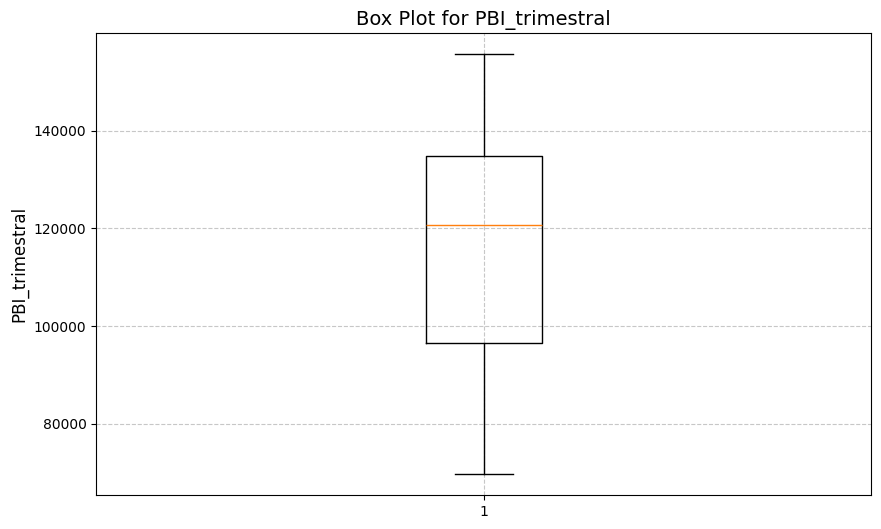

------------------------------------------------------------
Outliers usando Z-Score method:
Total: 1
------------------------------------------------------------
Outliers using IQR method:
Total: 0


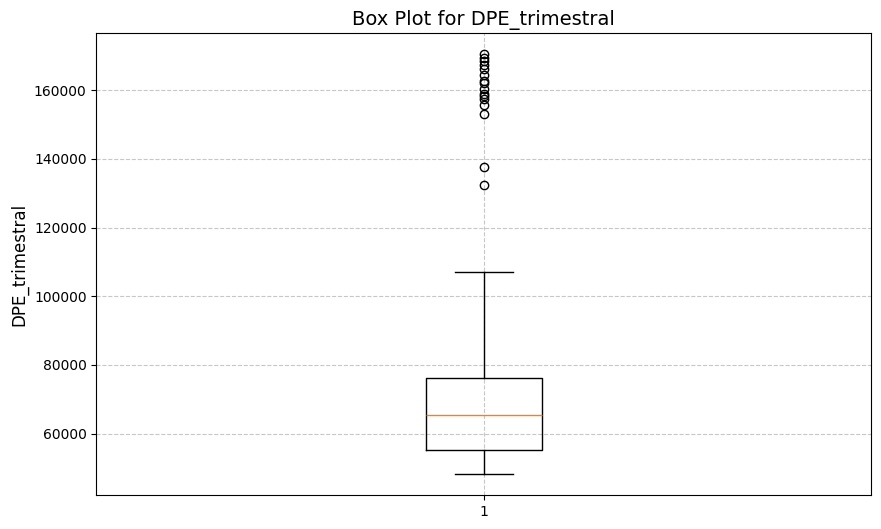

------------------------------------------------------------
Outliers usando Z-Score method:
Total: 5
------------------------------------------------------------
Outliers using IQR method:
Total: 16


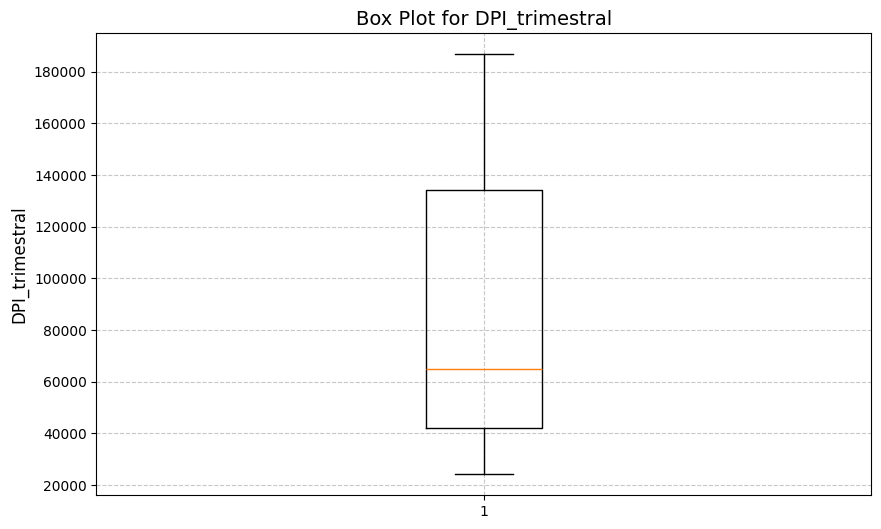

------------------------------------------------------------
Outliers usando Z-Score method:
Total: 1
------------------------------------------------------------
Outliers using IQR method:
Total: 0


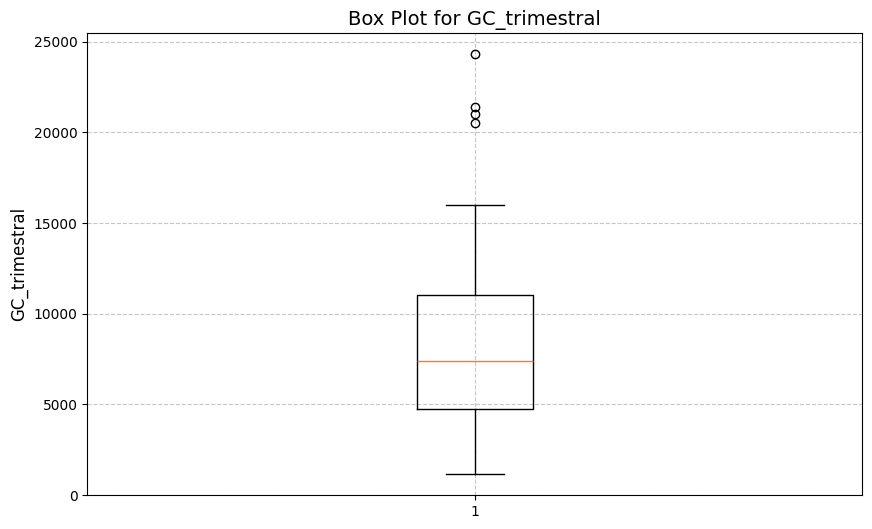

------------------------------------------------------------
Outliers usando Z-Score method:
Total: 4
------------------------------------------------------------
Outliers using IQR method:
Total: 4


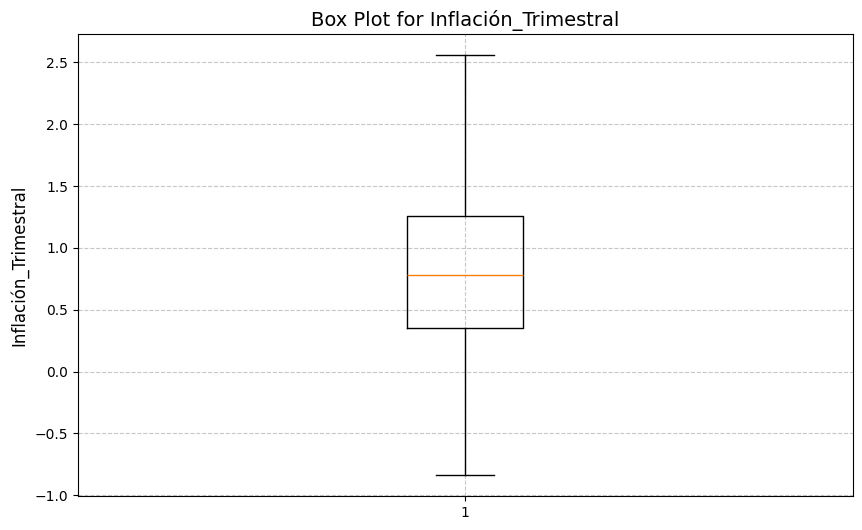

------------------------------------------------------------
Outliers usando Z-Score method:
Total: 3
------------------------------------------------------------
Outliers using IQR method:
Total: 0


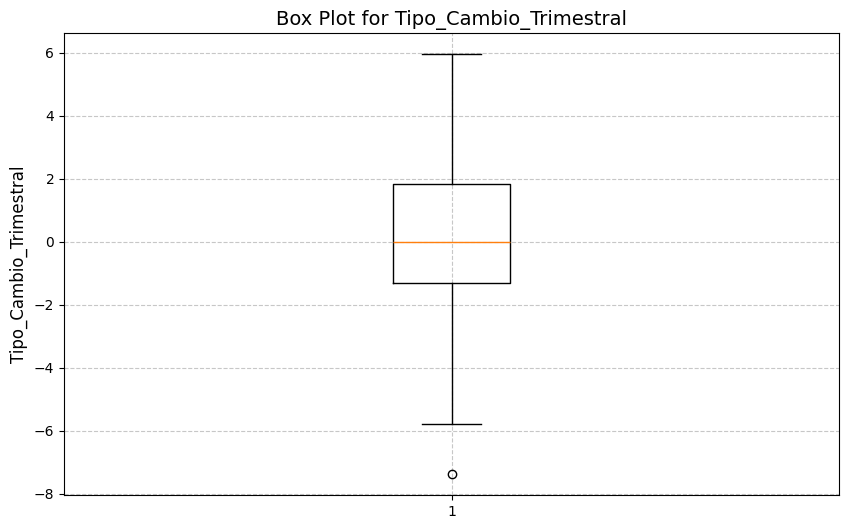

------------------------------------------------------------
Outliers usando Z-Score method:
Total: 5
------------------------------------------------------------
Outliers using IQR method:
Total: 1
¿Qué tipo de metodología prefieres usar?
a. Z-Score.
b. Capping/ Flooring Outliers (IQR).
c. Log Transformación.
Seleccione opción: B
Outliers limitados por el método IQR con éxito.
¿Qué tipo de metodología prefieres usar?
a. Z-Score.
b. Capping/ Flooring Outliers (IQR).
c. Log Transformación.
Seleccione opción: B
Outliers limitados por el método IQR con éxito.
¿Qué tipo de metodología prefieres usar?
a. Z-Score.
b. Capping/ Flooring Outliers (IQR).
c. Log Transformación.
Seleccione opción: B
Outliers limitados por el método IQR con éxito.


In [4]:
#%% PREPROCESAMIENTO DE DATOS
def missing_values(df: pd.DataFrame):
    """
    Reporte General sobre la situación de los datos descargados.
    """
    # Cantidad de datos faltantes.
    df = df
    missing_data = df.isnull().sum()

    return print(f"Cantidad de datos faltantes:\n {missing_data}")

# Revisar si hay datos faltantes
missing_values(y) # No los hay
missing_values(x) # No los hay

# OUTLIERS
def outliers(df: pd.DataFrame, column: str='Close'):
    # Por observar: CON RETORNOS (ESTACIONARIOS PRIMERO)
    # Identificar valores atípicos (Close)
    # 1. Box Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Crear boxplot
    ax.boxplot(df[column].dropna(), vert=True)  # `vert=True` para orientación vertical

    # Personalizar título y etiquetas
    ax.set_title(f'Box Plot for {column}', fontsize=14)
    ax.set_ylabel(column, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

    # Mostrar el gráfico
    plt.show()

    # 2. Z-Score
    # La puntuación z indica a cuántas desviaciones estándar se encuentra un elemento
    # de la media. Normalmente, una puntuación z mayor que dos o menor que -2,
    # a veces mayor que tres o menor que -3, se considera un valor atípico.
    # Calcular el z-score
    df['Z_score'] = (df[column] - df[column].mean()) / df[column].std()

    # Identificar el Outliers
    outliers_z_score = df[np.abs(df['Z_score']) > 2]
    print("---" * 20)
    print("Outliers usando Z-Score method:")
    print(f"Total: {len(outliers_z_score)}")

    # 3. Interquartile Range (IQR)
    # El RIQ oscila entre el primer cuartil (percentil 25) y el
    # tercer cuartil (percentil 75). Los valores atípicos suelen definirse como
    # puntos de datos que se encuentran más allá de 1,5 veces el RIQ por encima
    # del tercer cuartil o por debajo del primer cuartil.
    # Calcular el IQR
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Identificar el Outlier
    outliers_iqr = df[(df[column] < (Q1 - 1.5 * IQR)) |
    (df[column] > (Q3 + 1.5 * IQR))]

    print("---" * 20)
    print("Outliers using IQR method:")
    print(f"Total: {len(outliers_iqr)}")

    return outliers_z_score, outliers_iqr

# Verificar si existen datos atípicos en las series
# Variable Dependiente
z_score, iqr = outliers(y, column="PBI_trimestral") # 1, 0
# Variable Independiente
z_score, iqr = outliers(x, column="DPE_trimestral") # 5, 16 -> Exceso de outliers por COVID / Log
z_score, iqr = outliers(x, column="DPI_trimestral") # 1, 0 -> Log para que vaya a la par con el DPE
z_score, iqr = outliers(x, column="GC_trimestral") # 4, 4 -> Exceso de outliers continuos / Log
z_score, iqr = outliers(x, column="Inflación_Trimestral") # 3, 0
z_score, iqr = outliers(x, column="Tipo_Cambio_Trimestral") # 5, 1 -> IQR

# Conclusión:
# - Necesario el tratamiento de outliers.
# - Metodología a utilizar: Log

def outliers_management(df: pd.DataFrame, column: str='Close'):

    # Tipos de Manjeos de Outliers
    print("¿Qué tipo de metodología prefieres usar?")
    print("a. Z-Score.")
    print("b. Capping/ Flooring Outliers (IQR).")
    print("c. Log Transformación.")
    opciones = input("Seleccione opción: ").lower()

    # Tratar Outliers
    if opciones == 'a':
        # Calculate Z-scores
        df['Z_score'] = (df[column] - df[column].mean()) / df[column].std()

        # Eliminar outliers usando z-score método
        df = df[np.abs(df['Z_score']) <= 2]
        df = df.drop(columns=['Z_score'])
        print("Outliers eliminados por el método Z-Score con éxito.")
        return df

    elif opciones == 'b':
        # Límites mínimos los cuales se reducidas su influencia como outliers.
        # Calcular IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        # Limitación de Outliers usando IQR método
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = np.where(df[column] > upper_bound, upper_bound,
                                      np.where(df[column] < lower_bound, lower_bound, df[column]))

        print("Outliers limitados por el método IQR con éxito.")

        return df

    elif opciones == 'c':
        # Log transformation to reduce the impact of outliers
        df[f'log_{column}'] = np.log(df[column])
        print("Outliers transformados por el método Log con éxito.")

        return df

    else:
        RuntimeError("Introducir alternativa válida.")

y = y.drop(["Z_score"], axis=1)
x = x.drop(["Z_score"], axis=1)

# Para PBI
y["PBI_trimestral_IQR"] = outliers_management(y, column="PBI_trimestral")

# Para X
x["log_DPE_trimestral"] = np.log(x["DPE_trimestral"])
x["log_DPI_trimestral"] = np.log(x["DPI_trimestral"])
x["log_GC_trimestral"] = np.log(x["GC_trimestral"])
x["Inflación_Trimestral_IQR"] = outliers_management(x[["Inflación_Trimestral"]], column="Inflación_Trimestral")
x["Tipo_Cambio_Trimestral_IQR"] = outliers_management(x[["Tipo_Cambio_Trimestral"]], column="Tipo_Cambio_Trimestral")

# Drop columns
x = x.drop(x.columns[:5], axis=1)
y = y.iloc[:, [1]]

KPSS Statistic: 0.3231591205024562
p-value: 0.01
Number of lags used: 3
Critical Values:
  10% : 0.119
  5% : 0.146
  2.5% : 0.176
  1% : 0.216

📌 Interpretación:
Conclusión: La serie NO es estacionaria (se rechaza H₀).
→ No es estacionaria en nivel con tendencia.
KPSS Statistic: 0.2957395349731185
p-value: 0.01
Number of lags used: 5
Critical Values:
  10% : 0.119
  5% : 0.146
  2.5% : 0.176
  1% : 0.216

📌 Interpretación:
Conclusión: La serie NO es estacionaria (se rechaza H₀).
→ No es estacionaria en nivel con tendencia.
KPSS Statistic: 0.12736388856695777
p-value: 0.08451131746859672
Number of lags used: 5
Critical Values:
  10% : 0.119
  5% : 0.146
  2.5% : 0.176
  1% : 0.216

📌 Interpretación:
Conclusión: La serie ES estacionaria (no se rechaza H₀).
→ Estacionaria en nivel con tendencia.
KPSS Statistic: 0.25109237907919685
p-value: 0.01
Number of lags used: 1
Critical Values:
  10% : 0.119
  5% : 0.146
  2.5% : 0.176
  1% : 0.216

📌 Interpretación:
Conclusión: La serie NO es esta

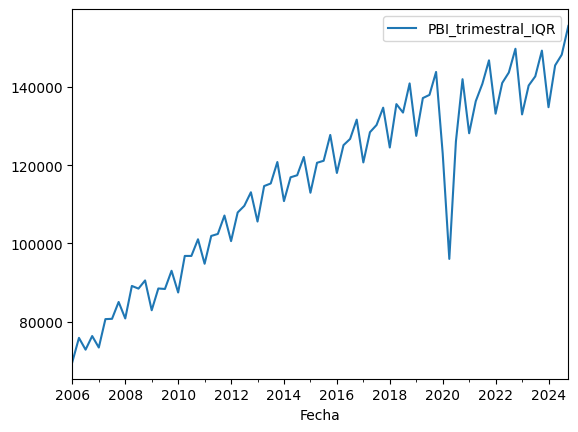

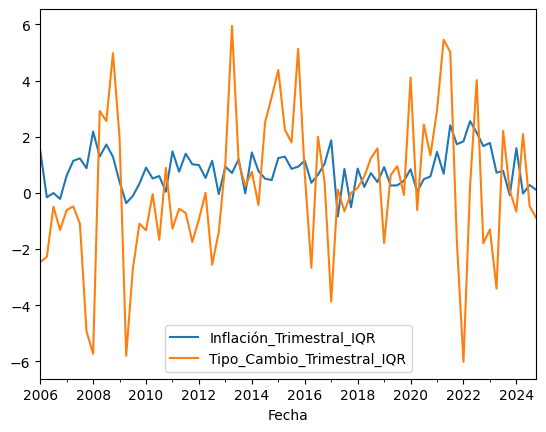

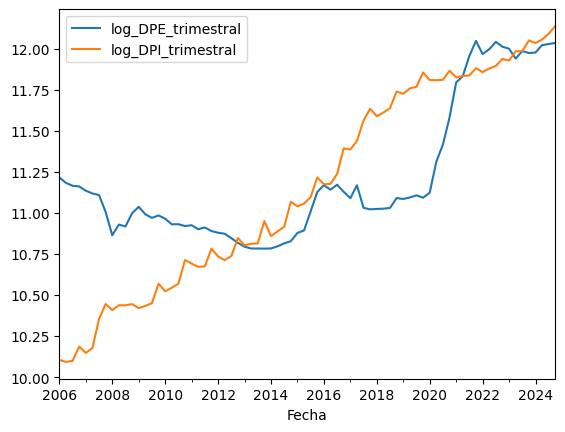

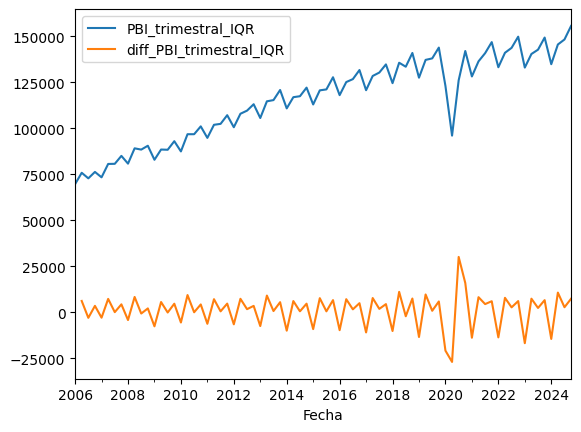

In [5]:
#%% INGENIERIA DE DATOS
# A. Estacionarización
def adf_test(df: pd.DataFrame, column: str = 'Close', regression: str = 'ct'):
    """
    Realiza la prueba de Dickey-Fuller aumentada (ADF) sobre una columna de un DataFrame.

    Parámetros:
      - df: pd.DataFrame con los datos de series temporales.
      - column: str, el nombre de la columna a evaluar.
      - regression: str, tipo de regresión ('c', 'ct', 'n').
    """
    if column not in df.columns:
        raise ValueError(f"La columna '{column}' no está en el DataFrame.")

    series = df[column].dropna()
    result = adfuller(series, regression=regression, autolag='AIC')

    print("📌 Hipótesis del test ADF:")
    print("  H₀: La serie tiene una raíz unitaria (NO estacionaria).")
    print("  H₁: La serie es estacionaria.\n")

    print(f'ADF Statistic for {column}: {result[0]}')
    print(f'p-value for {column}: {result[1]}')
    print(f'# Lags used: {result[2]}')
    print(f'# Observations: {result[3]}\n')

    # Evaluación
    if result[1] <= 0.05:
        print(f"✅ Conclusión: La serie '{column}' es ESTACIONARIA (rechazamos H₀, p ≤ 0.05).")
    else:
        print(f"⚠️ Conclusión: La serie '{column}' NO es estacionaria (no se rechaza H₀, p > 0.05).")

    print("\n📊 Valores críticos:")
    for key, value in result[4].items():
        nivel = "Estacionaria" if result[0] < value else "No estacionaria"
        print(f"  {key}%: {value:.3f} → {nivel} a este nivel")

    return None #result  # opcional, si deseas usar los valores luego

def run_kpss_test(series, regression='ct', nlags='auto'):
    """
    Ejecuta la prueba KPSS en la serie indicada.

    Parámetros:
      - series: La serie temporal (pandas.Series) a testear.
      - regression: Tipo de regresión ('c' para constante, 'ct' para constante y tendencia).
      - nlags: Número de lags a utilizar (puede ser 'auto').

    Imprime:
      - KPSS Statistic, p-value, valores críticos y una conclusión sobre la estacionariedad.
    """
    from statsmodels.tsa.stattools import kpss

    statistic, p_value, n_lags, critical_values = kpss(series, regression=regression, nlags=nlags)

    print("KPSS Statistic:", statistic)
    print("p-value:", p_value)
    print("Number of lags used:", n_lags)
    print("Critical Values:")
    for key, value in critical_values.items():
        print(f"  {key} : {value}")

    # Interpretación
    print("\n📌 Interpretación:")
    if p_value < 0.05:
        print("Conclusión: La serie NO es estacionaria (se rechaza H₀).")
        if regression == 'ct':
            print("→ No es estacionaria en nivel con tendencia.")
        else:
            print("→ No es estacionaria en nivel.")
    else:
        print("Conclusión: La serie ES estacionaria (no se rechaza H₀).")
        if regression == 'ct':
            print("→ Estacionaria en nivel con tendencia.")
        else:
            print("→ Estacionaria en nivel (sin tendencia).")

run_kpss_test(y) # No estacionaria
run_kpss_test(x[["log_DPE_trimestral"]]) # No estacionaria
run_kpss_test(x[["log_DPI_trimestral"]]) # Estacionaria
run_kpss_test(x[["log_GC_trimestral"]]) # No estacionaria
run_kpss_test(x[["Inflación_Trimestral_IQR"]]) # Es Estacionaria
run_kpss_test(x[["Tipo_Cambio_Trimestral_IQR"]]) # Es Estacionaria.

adf_test(y, column="PBI_trimestral_IQR") # No estacionaria
adf_test(x, column="log_DPE_trimestral") # No es estacionaria
adf_test(x, column="log_DPI_trimestral") # Es estacionaria solo a 10%
adf_test(x, column="log_GC_trimestral") # No es estacionaria
adf_test(x, column="Inflación_Trimestral_IQR") # No es estacionaria a 1%
adf_test(x, column="Tipo_Cambio_Trimestral_IQR") # Es Estacionaria

y.plot()
x[["Inflación_Trimestral_IQR","Tipo_Cambio_Trimestral_IQR"]].plot()
x[["log_DPE_trimestral","log_DPI_trimestral"]].plot()

# Aplicar la Diferenciación Fraccionaria -> PBI_trimestral_IQR, log_DPE_trimestral, DPI_trimestral_IQR, log_GC_trimestral

# 1. PBI_trimestral_IQR
y["diff_PBI_trimestral_IQR"] = y["PBI_trimestral_IQR"].diff()
y.plot()
adf_test(y, column="diff_PBI_trimestral_IQR", regression="c") # Es Estacionaria
run_kpss_test(y["diff_PBI_trimestral_IQR"].iloc[1:], regression="c") # Es Estacionario

# 2. log_DPE_trimestral
x["diff_log_DPE_trimestral"] = x["log_DPE_trimestral"].diff()
adf_test(x[["diff_log_DPE_trimestral"]], column="diff_log_DPE_trimestral") # Es Estacionaria (mayor 5%)
run_kpss_test(x["diff_log_DPE_trimestral"].iloc[1:], regression="c") # Es Estacionaria

# 3. diff_log_DPI_trimestral
x["diff_log_DPI_trimestral"] = x["log_DPI_trimestral"].diff()
adf_test(x[["diff_log_DPI_trimestral"]], column="diff_log_DPI_trimestral") # No es Estacionaria
run_kpss_test(x["diff_log_DPI_trimestral"].iloc[1:], regression="c", nlags="auto") # Es Estacionaria

# 4. log_GC_trimestral
x["diff_2_log_GC_trimestral"] = x["log_GC_trimestral"].diff().diff()
adf_test(x[["diff_2_log_GC_trimestral"]], column="diff_2_log_GC_trimestral", regression="c") # Es Estacionaria
run_kpss_test(x["diff_2_log_GC_trimestral"].iloc[2:], regression="c", nlags="auto") # Es Estacionaria

# Quedarnos con los valores que coincidan con el índice de y.
x = x.drop(x.columns[:3], axis=1)
x = x.dropna()
y = y["diff_PBI_trimestral_IQR"].dropna()
y = y.loc[y.index.intersection(x.index)]

# B. SPLIT DE DATOS
split = 0.2
x_train, x_test = train_test_split(x ,test_size=split, shuffle=False)
y_train, y_test = train_test_split(y ,test_size=split, shuffle=False)

y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# C. NORMALIZACION
# Normalización -> Para hacerlos escalable (no asumen una distribución de los datos)
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

# Entrenar la Data Transformada
x_train_scaler = scaler_X.fit_transform(x_train)
x_test_scaler = scaler_X.transform(x_test)

y_train_scaler = scaler_Y.fit_transform(y_train)


Fitting 5 folds for each of 1440 candidates, totalling 7200 fits

GridSearch completado en 190.1s
Mejores parámetros: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 1.0}

Train → MSE: 1799569.8750, MAE: 925.5894, R²: 0.9770
Test  → MSE: 18728410.0000, MAE: 3470.3259, R²: 0.7529
Correlación Train: 0.9912
Correlación Test : 0.9178


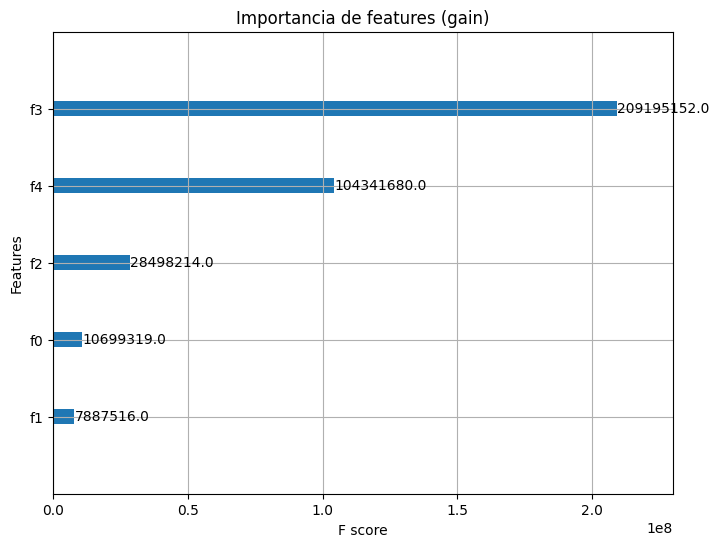

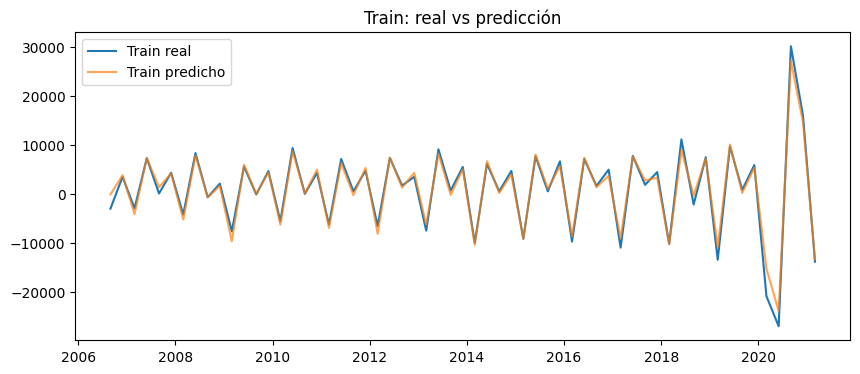

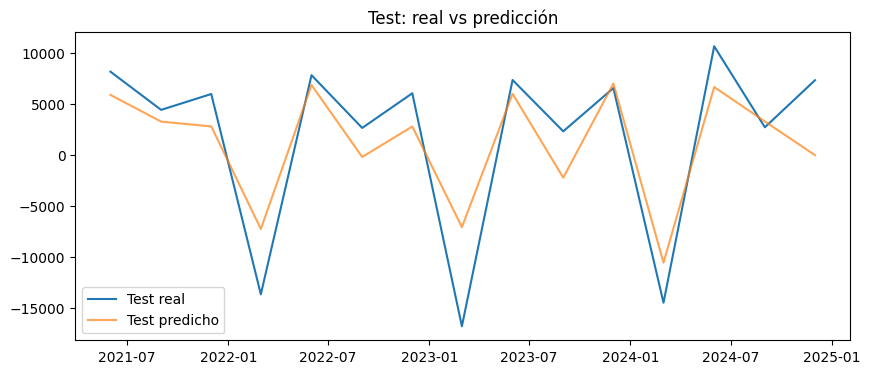

In [6]:
#%% MODELO - XGBoost
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1) Split temporal
tscv = TimeSeriesSplit(n_splits=5)

# 2) Grid reducido para evitar búsquedas excesivas
param_grid_small = {
    'n_estimators':     [30, 50, 70, 100, 150],
    'learning_rate':    [0.01, 0.05],
    'max_depth':        [3, 6],
    'gamma':            [0, 0.1],
    'subsample':        [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha':        [0, 0.01, 0.1],  # L1 regularización
    'reg_lambda':       [1, 5, 10]      # L2 regularización
}

# 3) Modelo base
base_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=1,
    verbosity=0,
    n_jobs=-1
)

# 4) GridSearchCV con TimeSeriesSplit (sin early stopping dentro)
grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid_small,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)

# 5) Búsqueda de hiperparámetros (solo entrenamiento)
start = time.time()
grid.fit(x_train_scaler, y_train)
print(f"\nGridSearch completado en {time.time() - start:.1f}s")
print('Mejores parámetros:', grid.best_params_)

# 6) Modelo final con early stopping configurado en el constructor
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=1,
    verbosity=0,
    n_jobs=-1,
    **grid.best_params_,
    eval_metric='rmse',            # métrica de validación
    early_stopping_rounds=20       # parará si no mejora en validación interna
)

# Definir validación para early stopping (parte de test o split adicional)
eval_set = [(x_test_scaler, y_test)]

# 7) Entrenamiento final
best_model.fit(
    x_train_scaler, y_train,
    eval_set=eval_set,
    verbose=False
)

# 8) Predicciones
y_train_pred = best_model.predict(x_train_scaler)
y_test_pred  = best_model.predict(x_test_scaler)

# 9) Métricas de error
mse_tr = mean_squared_error(y_train, y_train_pred)
mae_tr = mean_absolute_error(y_train, y_train_pred)
r2_tr  = r2_score(y_train, y_train_pred)

mse_te = mean_squared_error(y_test, y_test_pred)
mae_te = mean_absolute_error(y_test, y_test_pred)
r2_te  = r2_score(y_test, y_test_pred)

print(f"\nTrain → MSE: {mse_tr:.4f}, MAE: {mae_tr:.4f}, R²: {r2_tr:.4f}")
print(f"Test  → MSE: {mse_te:.4f}, MAE: {mae_te:.4f}, R²: {r2_te:.4f}")

# 10) Correlación real vs predicha
# Aplanar vectores y crear Series alineadas
train_true = pd.Series(np.ravel(y_train), index=y_train.index)
train_pred = pd.Series(y_train_pred.ravel() if hasattr(y_train_pred, 'ravel') else y_train_pred, index=y_train.index)

test_true = pd.Series(np.ravel(y_test), index=y_test.index)
test_pred = pd.Series(y_test_pred.ravel()  if hasattr(y_test_pred,  'ravel') else y_test_pred,  index=y_test.index)

corr_tr = train_true.corr(train_pred)
corr_te = test_true.corr(test_pred)
print(f"Correlación Train: {corr_tr:.4f}")
print(f"Correlación Test : {corr_te:.4f}")

# 11) Importancia de features (gain)
fig, ax = plt.subplots(figsize=(8, 6))
xgb.plot_importance(best_model, importance_type='gain', ax=ax)
ax.set_title('Importancia de features (gain)')
plt.show()

# 12) Gráficos de ajuste
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_train.index, y_train, label='Train real')
ax.plot(y_train.index, y_train_pred, label='Train predicho', alpha=0.7)
ax.legend(); ax.set_title('Train: real vs predicción')
plt.show()

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(y_test.index, y_test, label='Test real')
ax.plot(y_test.index, y_test_pred, label='Test predicho', alpha=0.7)
ax.legend(); ax.set_title('Test: real vs predicción')
plt.show()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 80)             │         6,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         4,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │         1,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,971 (46.76 KB)

 Trainable params: 11,971 (46.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 64556232.0000 - sign_accuracy: 0.3632 - val_loss: 79155344.0000 - val_sign_accuracy: 0.9375
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 63005940.0000 - sign_accuracy: 0.5728 - val_loss: 79153784.0000 - val_sign_accuracy: 0.8750
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 71024232.0000 - sign_accuracy: 0.8218 - val_loss: 79151768.0000 - val_sign_accuracy: 0.8750
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 117846800.0000 - sign_accuracy: 0.7826 - val_loss: 79150032.0000 - val_sign_accuracy: 0.9375
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 92772960.0000 - sign_accuracy: 0.7406 - val_loss: 79147432.0000 - val_sign_accuracy: 0.9375
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 69696200.0000 - sign_accuracy: 0.8562 - val_loss: 79142808.0000 - val_sign_accuracy: 1.0000
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 51039420.0000 - sign_accuracy: 0.

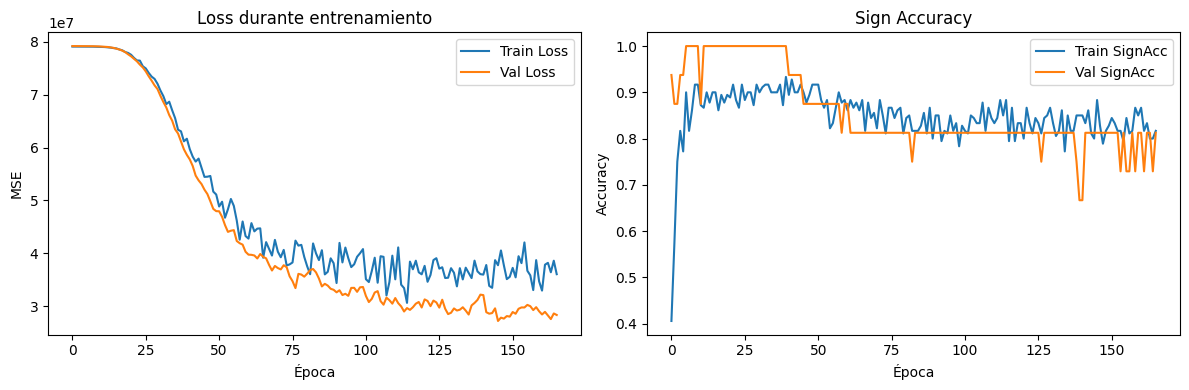

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Sign Accuracy Train: 81.67%
Sign Accuracy Val  : 81.25%
RMSE Train: 5840.263995505728
RMSE Test : 5220.021919016701
R2 Train : 0.5642438590909625
R2 Test  : 0.6405352976398309


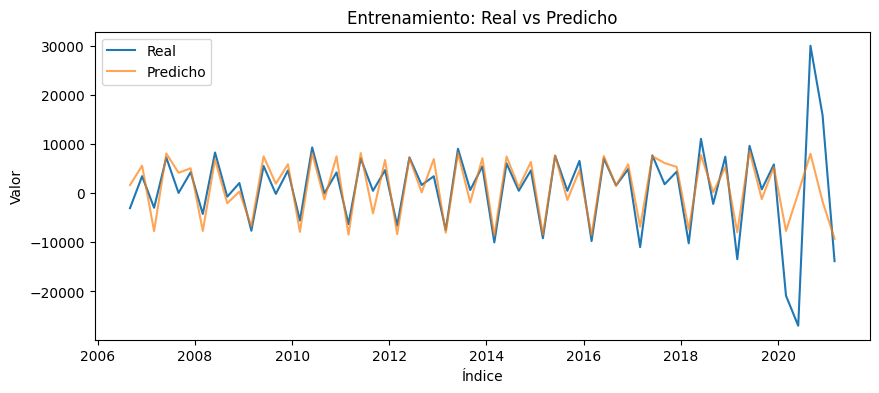

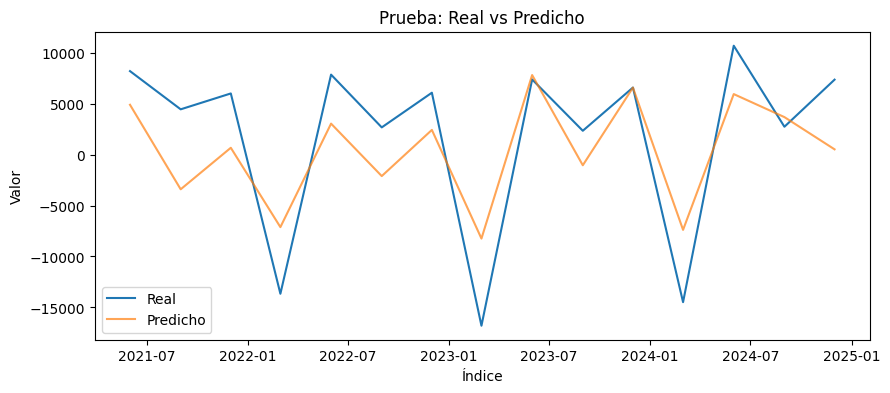

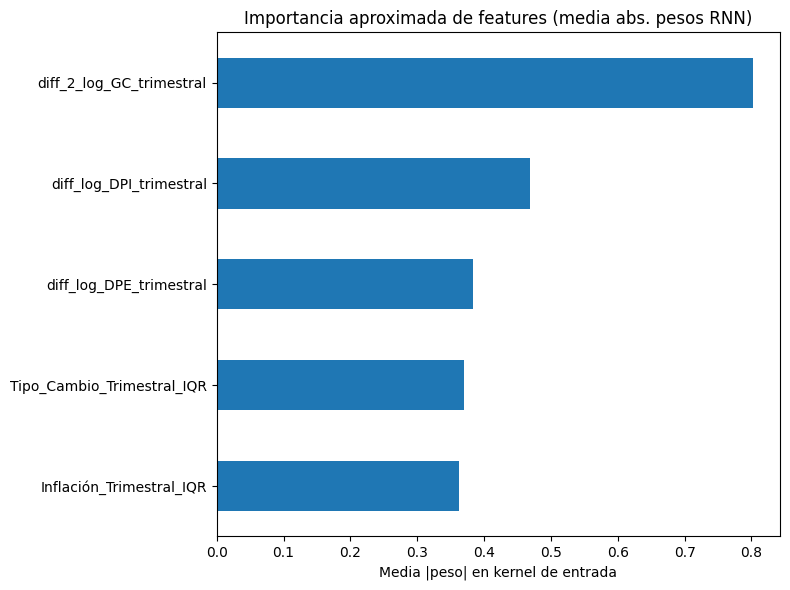

In [7]:
#%% MODELO - RED NEURONAL
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import mean_squared_error, r2_score

# Métrica custom para precisión de signo
def sign_accuracy(y_true, y_pred):
    return K.mean(K.equal(K.sign(y_true), K.sign(y_pred)))

# Preparamos datos
y_train_arr = y_train.values.reshape(-1, 1)
y_test_arr  = y_test.values.reshape(-1, 1)
x_train_rnn = x_train_scaler.reshape((x_train_scaler.shape[0], 1, x_train_scaler.shape[1]))
x_test_rnn  = x_test_scaler.reshape((x_test_scaler.shape[0], 1, x_test_scaler.shape[1]))

# Construcción del modelo RNN con regularización
tf_model = Sequential([
    SimpleRNN(units=80, input_shape=(1, x_train_rnn.shape[2]), activation='tanh', return_sequences=False),
    #BatchNormalization(),
    Dropout(0.2),

    Dense(50, activation='relu'),
    #BatchNormalization(),
    Dropout(0.2),

    Dense(20, activation='relu'),
    #BatchNormalization(),
    Dropout(0.2),

    Dense(1)
])

# Compilar modelo
tf_model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[sign_accuracy]
)

tf_model.summary()

# Early stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

# Entrenamiento con EarlyStopping
start = time.time()
history = tf_model.fit(
    x_train_rnn, y_train_arr,
    epochs=500,
    batch_size=4,
    validation_data=(x_test_rnn, y_test_arr),
    callbacks=[early_stop],
    verbose=1
)
print(f"Tiempo de entrenamiento: {time.time() - start:.1f}s")

# Visualización de pérdida y sign accuracy
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history.history['loss'], label='Train Loss')
ax[0].plot(history.history['val_loss'], label='Val Loss')
ax[0].set_title('Loss durante entrenamiento')
ax[0].set_xlabel('Época')
ax[0].set_ylabel('MSE')
ax[0].legend()

ax[1].plot(history.history['sign_accuracy'], label='Train SignAcc')
ax[1].plot(history.history['val_sign_accuracy'], label='Val SignAcc')
ax[1].set_title('Sign Accuracy')
ax[1].set_xlabel('Época')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
plt.tight_layout()
plt.show()

# Predicciones
y_train_pred = tf_model.predict(x_train_rnn).flatten()
y_test_pred  = tf_model.predict(x_test_rnn).flatten()

# Métricas de evaluación
# Últimos valores de sign_accuracy (en escala 0–1)
train_sign_acc = history.history['sign_accuracy'][-1]
val_sign_acc   = history.history['val_sign_accuracy'][-1]

print(f"Sign Accuracy Train: {train_sign_acc * 100:.2f}%")
print(f"Sign Accuracy Val  : {val_sign_acc   * 100:.2f}%")
print('RMSE Train:', np.sqrt(mean_squared_error(y_train_arr, y_train_pred)))
print('RMSE Test :', np.sqrt(mean_squared_error(y_test_arr, y_test_pred)))
print('R2 Train :', r2_score(y_train_arr, y_train_pred))
print('R2 Test  :', r2_score(y_test_arr, y_test_pred))

# Gráficos Real vs Predicción
def plot_actual_vs_pred(idx, true, pred, title):
    plt.figure(figsize=(10,4))
    plt.plot(idx, true.flatten(), label='Real')
    plt.plot(idx, pred,        label='Predicho', alpha=0.7)
    plt.title(title)
    plt.xlabel('Índice')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

plot_actual_vs_pred(y_train.index, y_train_arr, y_train_pred, 'Entrenamiento: Real vs Predicho')
plot_actual_vs_pred(y_test.index,  y_test_arr,  y_test_pred,  'Prueba: Real vs Predicho')

# Extraer Características más importantes
# Convertir a lista el nombre de características
feature_names = x_train.columns.tolist()

# Consultar y extraer los pesos de la capa SimpleRNN
kernel_weights, recurrent_weights, rnn_bias = tf_model.layers[0].get_weights()

# kernel_weights.shape == (n_features, units)
# Para cada feature, calculamos la media de valores absolutos a lo largo de las unidades
importances = np.mean(np.abs(kernel_weights), axis=1)

# Convertir a un Series y lo ordenamos de mayor a menor
imp_series = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Graficar
plt.figure(figsize=(8, 6))
imp_series.plot(kind='barh')
plt.title("Importancia aproximada de features (media abs. pesos RNN)")
plt.xlabel("Media |peso| en kernel de entrada")
plt.gca().invert_yaxis()  # para que la de mayor importancia quede arriba
plt.tight_layout()
plt.show()
